# DLAV Project - Phase 3

In this notebook we will train a very simple planner and test its real-world performance.


The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [2]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if"
output_zip = "dlav_val_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5"
output_zip = "test_public_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=4fa4a74a-01bd-47ad-afd4-aded42191450
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:02<00:00, 179MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if
From (redirected): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if&confirm=t&uuid=d586903a-d891-4156-b94f-9530928dfcf5
To: /content/dlav_val_real.zip
100%|██████████| 129M/129M [00:00<00:00, 232MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5
From (redirected): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5&confirm=t&uuid=e3bdd821-9412-4e8f-939f-cd12fc485656
To: /content/test_public_real.zip
100%|██████████| 110M/110M [00:01<00:00, 107MB/s] 


In [3]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pickle
import time
import pandas as pd


Now lets load the data and visualize how the real data looks like!

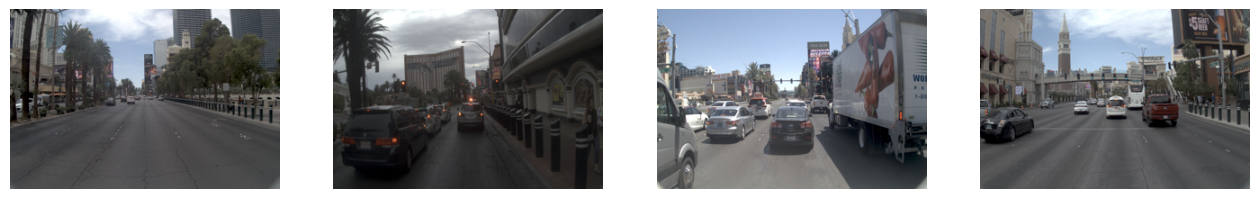

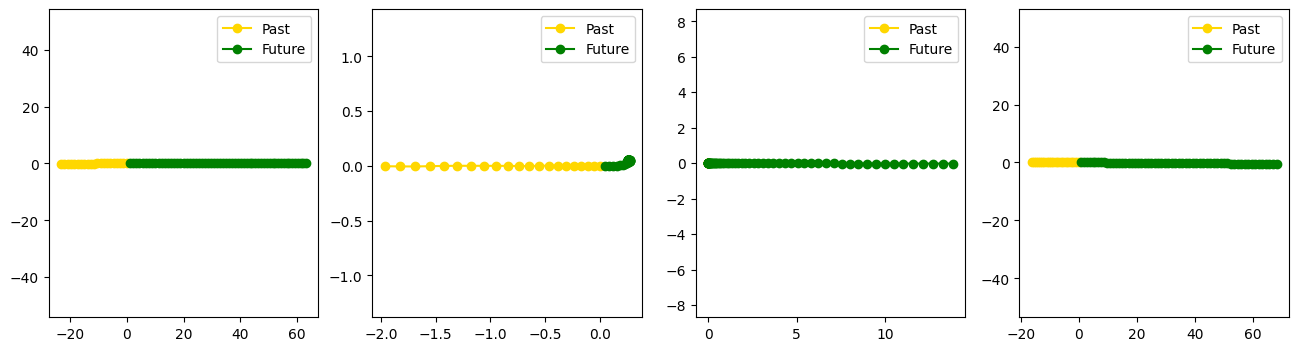

In [4]:

import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import os
k = 4
# load the data
data = []
test_files = os.listdir("val_real")

for i in range(k):
    with open(f"val_real/{test_files[i]}", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now let's train the model with synthetic data and test it with the real-world data.

In [5]:
class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

        self.transform = transforms.Compose([
            transforms.RandomAffine(degrees =0, translate=(0.05, 0.05), scale=(0.9, 1.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3, hue=0.1),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load pickle file
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # Load image and normalize
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        if not self.test:
            camera = self.transform(camera)
            future = torch.FloatTensor(data['sdc_future_feature'])


        # Load other inputs
        history = torch.FloatTensor(data['sdc_history_feature'])

        # Apply horizontal flip with 50% chance
        if not self.test and random.random() < 0.5:
            camera = torch.flip(camera, dims=[2])  # Horizontal flip
            history = self.horizontal_flip_trajectory(history)
            future = self.horizontal_flip_trajectory(future)

        # Add small Gaussian noise to trajectories
        if not self.test:
            history += torch.randn_like(history) * 0.01
            future += torch.randn_like(future) * 0.01

        history_aug = torch.zeros((21, 9), dtype=torch.float32)
        history_aug[:, 0:3] = history
        vel = history[1:] - history[:-1]            # shape [20, 3]
        history_aug[1:, 3:6] = vel                  # zero velocity for t=0
        acc = vel[1:] - vel[:-1]                    # shape [19, 3]
        history_aug[2:, 6:9] = acc

        # Return dictionary
        if not self.test:
          return {
            'camera': camera,
            'history': history_aug,
            'future': future,
          }
        else:
          return {
            'camera': camera,
            'history': history_aug,
          }


    def horizontal_flip_trajectory(self, trajectory):
        # create a copy of the trajectory
        flipped = trajectory.clone()
        flipped[:,1] = -flipped[:, 1]
        return flipped



In [6]:
from google.colab import files
uploaded = files.upload()

Saving logger_phase3_simple2_fine2.pkl to logger_phase3_simple2_fine2.pkl


In [7]:
class Logger:
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        self.train_loss = []
        self.ADE = []
        self.FDE = []
        self.MSE = []

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        for k, v in metrics.items():
            if k == "train_loss":
                self.train_loss.append(v)
            elif k == "ADE":
                self.ADE.append(v)
            elif k == "FDE":
                self.FDE.append(v)
            elif k == "MSE":
                self.MSE.append(v)



In [8]:
import pickle

#
with open("logger_phase3_simple2_fine2.pkl", "rb") as f:
    logger = pickle.load(f)

#
print(logger.train_loss)
print(logger.ADE)
print(logger.FDE)
print(logger.MSE)

[28.77550441442534, 10.566471341044403, 10.419073911600334, 9.396904848342718, 9.064019271107608, 8.5449322642282, 8.206213030704232, 7.438160535901091, 7.386043153529943, 6.597634609355483, 6.3312924629033995, 5.838249698627827, 5.996389402206554, 5.6660791580067125, 5.571350948755131, 4.900344951208248, 4.770464344773182, 5.04508683501288, 4.8243177616318995, 4.634608106557713, 4.371589455493661, 4.075196307065875, 4.4381221914014155, 4.008204622324123, 3.8948877814204192, 3.8886266926000284, 3.80190900037455, 3.4445705060348955, 3.6821784377098083, 3.568764870249948, 3.5380678863026374, 3.7962784441404565, 3.5719587102878925, 3.236176942670068, 3.272967872924583, 3.2548551122809566, 3.2851034680078195, 3.3528936394425326, 3.0003981534824815, 3.0565857305083166, 2.934997399532518, 2.9496182788943135, 2.8593517541885376, 2.630128730175107, 2.600176612305087, 2.798824825259142, 2.74644391342651, 2.675632721462915, 2.601691489995912, 2.7286395964234376, 2.731262580599896, 2.549458994421

# Driving Planner

We initially went with :
- deep encoders and decoders
- heavy pretrained backbone CNN (ResNet50 or EfficientNet_b4)
- Losses for :
  - smoothness
  - jerky acceleration
  - heading


However we were getting bad performance (ADE above 2).
So we went much simpler and for this data is seems to have worked out well.

We noticed that our model seemed to still be learing in the training loss, but all the validation metrics were stagnating long before, which indicated we were probably overfitting. So a simpler model with shorter training made sense.

We now have:
- simple encoders and decoders
- small pretrained backbone CNN (mobilenet_v3_small)
- Loss : MSE on the prediction.

We get great performance, part of that is probably due to the pretrained backbone that does better on real data than on synthetic data. Now our ADE quickly reaches 1.6

In [9]:
class DrivingPlanner(nn.Module):
  def __init__(self):
      super().__init__()


      self.pretrained_CNN = self._get_pretrained_backbone()
      backbone_output_dim = 576       # mobilenet_v3_small
      # backbone_output_dim = 2048         # resnet50


      CNN_out_dim = 256
      self.cnn_backbone = nn.Sequential(
          nn.Conv2d(backbone_output_dim, CNN_out_dim,  kernel_size=5, stride=2, padding=2),
          nn.BatchNorm2d(CNN_out_dim),
          nn.ReLU(),
          nn.AdaptiveAvgPool2d((2, 2)),
          nn.Dropout(0.3)  # Preventing Overfitting
      )

      self.cnn_flatten = nn.Flatten()

      #############################
      # 2 : Trajectory history Encoder
      #############################

      hist_enc_out_dim = 256
      self.history_encoder = nn.Sequential(
            nn.Linear(21 * 9, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            )

      stack_output_dim = CNN_out_dim*2*2 + hist_enc_out_dim

      ################################
      # 4 : Decoders for Future Trajectory
      ################################
      self.trajectory_decoder = nn.Sequential(
          nn.Linear(stack_output_dim, 512),
          nn.ReLU(),
          nn.Dropout(0.2),

          nn.Linear(512, 512),
          nn.ReLU(),

          nn.Linear(512, 60 * 3)  # Output layer remains the same
      )


  def forward(self, camera, history):
      ###############################
      # 1 : Camera Encoder
      ###############################

      img_post_effNet = self.pretrained_CNN(camera)                       # (B, 1792, 7, 10)
      img_post_CNN = self.cnn_backbone(img_post_effNet)                   # (B, 128, 7, 10)
      img_feat_flat = self.cnn_flatten(img_post_CNN)                      # (B, 256*2*2) = (B, 1024)

      ###############################
      # 2 : Trajectory history Encoder
      ###############################

      hist_feat = self.history_encoder(history.view(history.size(0), -1)) # (B, 128)

      feat = torch.cat([img_feat_flat, hist_feat], dim=-1)      # (B, 1024 + 256) => (B, 1280)

      ###############################
      # 3 : Prediction Decoder
      ###############################

      future = self.trajectory_decoder(feat).view(-1, 60, 3)                              # (B, 60, 3)

      return future

  def _get_pretrained_backbone(self):
      # Load with pretrained weights
      mobilenet = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

      # Remove classifier (last layer)
      backbone = nn.Sequential(*list(mobilenet.features))

      # Freeze
      trainable_layers = list(backbone.children())[-3:] # Only fine-tune last 3 blocks
      for param in backbone.parameters():
          param.requires_grad = False
      for layer in trainable_layers:
          for param in layer.parameters():
              param.requires_grad = True

      return backbone

In [ ]:
def train_one_epoch(model, train_loader, optimizer, device):
    model.train()
    # criterion = nn.SmoothL1Loss()  #
    train_loss = 0.0

    for batch in train_loader:
        cam, hist, fut = [batch[k].to(device) for k in ['camera', 'history', 'future']]
        optimizer.zero_grad()
        fut_pred = model(cam, hist)

        traj_loss = F.mse_loss(fut_pred[..., :2], fut[..., :2])
        loss = traj_loss

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, device):
    model.eval()
    total_ade, total_fde, total_mse = 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for batch in val_loader:

            cam = batch['camera'].to(device)           # (batch, 3, H, W)
            hist = batch['history'].to(device)         # (batch, 21, 3)
            fut = batch['future'].to(device)           # (batch, 60, 3)

            fut_pred = model(cam, hist)

            B, T, _ = fut.shape
            count += B

            ade = torch.norm(fut_pred[:, :, :2] - fut[:, :, :2], dim=2).mean(dim=1).sum()
            fde = torch.norm(fut_pred[:, -1, :2] - fut[:, -1, :2], dim=1).sum()
            mse = F.mse_loss(fut_pred, fut, reduction='sum')

            total_ade += ade.item()
            total_fde += fde.item()
            total_mse += mse.item()


    ade_avg = total_ade / count
    fde_avg = total_fde / count
    mse_avg = total_mse / (count * T * 3)

    return ade_avg, fde_avg, mse_avg

def train(model, train_loader, val_loader, optimizer, logger, num_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    min_ade = 1.8

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        ade, fde, mse = validate(model, val_loader, device)

        # save the model with the best ADE performance
        if ade < min_ade:
            min_ade = ade
            print(f"Saving model with ADE: {min_ade:.3f}")
            torch.save(model.state_dict(), "model_phase3_simple2_fine.pth")

        logger.log(step=epoch, train_loss=train_loss, ADE=ade, FDE=fde, MSE=mse)
        print(f"Epoch {epoch+1}, Loss: {train_loss:.3f}, Validation - ADE: {ade:.3f}, FDE: {fde:.3f}, Traj MSE: {mse:.3f}")


In [21]:
num_workers = 2
batch_size = 32

train_data_dir = "train"
real_data_dir = "val_real"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
test_files = [os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir) if f.endswith('.pkl')]

train_files_mixed = train_files + test_files[:500]
test_files = test_files[500:]

train_dataset = DrivingDataset(train_files_mixed)
val_dataset = DrivingDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

# Train or load model

In [10]:
epochs = 100

start_time = time.time()
model = DrivingPlanner()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
logger = Logger()
train(model, train_loader, val_loader, optimizer, logger, num_epochs=epochs)

# save model as model_phase3_simple1
# torch.save(model.state_dict(), "model_phase3_simple2.pth")
# save the logger
with open("logger_phase3_simple2.pkl", "wb") as f:
    pickle.dump(logger, f)
# save the optimizer with learning rate
torch.save(optimizer.state_dict(), "optimizer_phase3_simple2.pth")

print("Training completed in {:.2f} seconds".format(time.time() - start_time))

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 94.8MB/s]


NameError: name 'train' is not defined

In [25]:
from google.colab import files
uploaded = files.upload()

Saving optimizer_phase3_simple2_fine.pth to optimizer_phase3_simple2_fine.pth


In [18]:
# load model
model = DrivingPlanner()
model.load_state_dict(torch.load("model_phase3_simple2_fine.pth"))
model.to(torch.device("cuda"))

DrivingPlanner(
  (pretrained_CNN): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size

In [12]:
# Load the logger
logger = Logger()
with open("logger_phase3_simple2_fine2.pkl", "rb") as f:
    log = pickle.load(f)
logger.train_loss = log.train_loss
logger.ADE = log.ADE
logger.FDE = log.FDE
logger.MSE = log.MSE

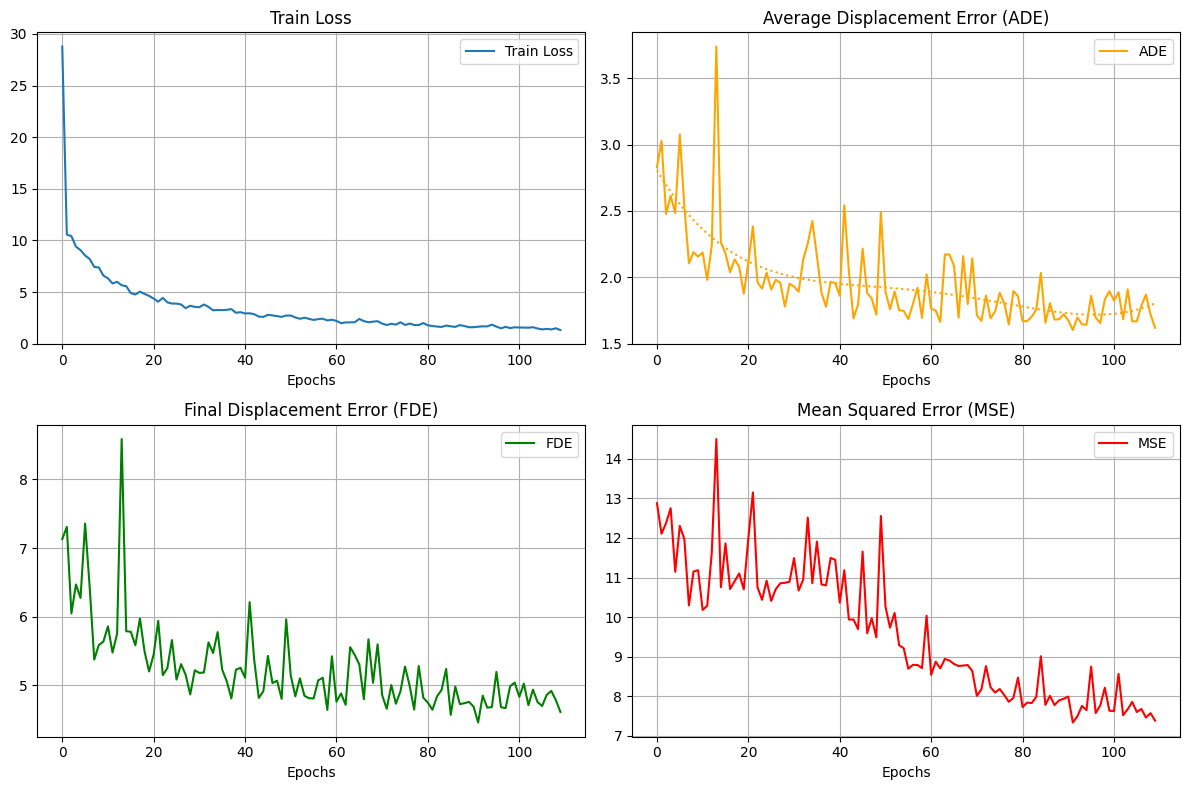

In [13]:
# visualize the validation metrics from the logger
def plot_metrics(logger):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    ax[0, 0].plot(logger.train_loss, label='Train Loss')
    ax[0, 0].set_title('Train Loss')
    ax[0, 1].plot(logger.ADE, label='ADE', color='orange')

    # regression line for ADE
    x = np.arange(len(logger.ADE))
    m = np.polyfit(x, logger.ADE, 4)
    ax[0, 1].plot(x, m[0]*x**4 +m[1]*x**3 +m[2]*x**2 + m[3]*x + m[4],":", color='orange')
    ax[0, 1].set_title('Average Displacement Error (ADE)')

    ax[1, 0].plot(logger.FDE, label='FDE', color='green')
    ax[1, 0].set_title('Final Displacement Error (FDE)')
    ax[1, 1].plot(logger.MSE, label='MSE', color='red')
    ax[1, 1].set_title('Mean Squared Error (MSE)')

    for a in ax.flatten():
        a.legend()
        a.grid()
        a.set_xlabel('Epochs')

    plt.tight_layout()
    plt.show()

plot_metrics(logger)

## Submission file creation

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


test_data_dir = "test_public_real"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=num_workers)

In [23]:

model.eval()
all_plans = []
device = 'cuda'
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase3_simple2.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (864, 121)


In [28]:
from google.colab import files
files.download('submission_phase3_simple2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

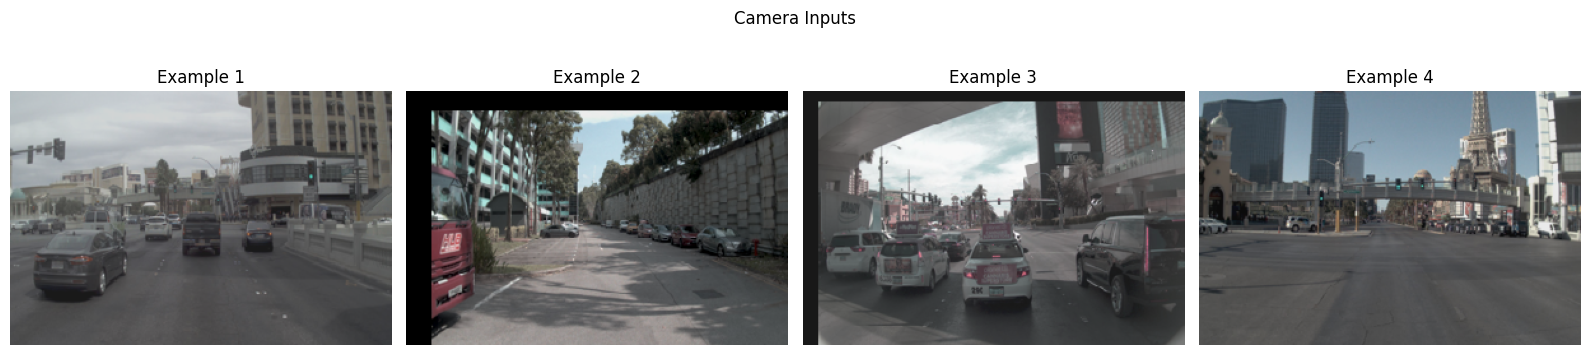

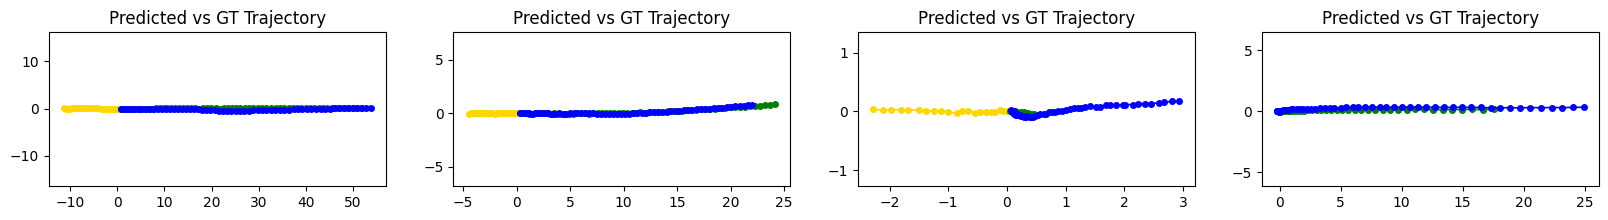

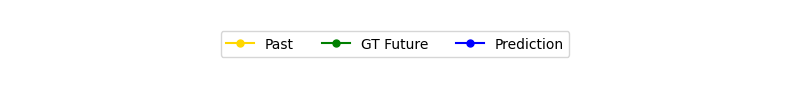

<Figure size 640x480 with 0 Axes>

In [24]:
from codeop import CommandCompiler
import matplotlib.pyplot as plt
import random

random.seed(40)

def visualize_comparison(val_loader, model, device):
    model.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)

    with torch.no_grad():
        pred = model(camera, history)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred = pred.cpu().numpy()

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(1, k, figsize=(5 * k, 2))
    for i, idx in enumerate(indices):
        ax[i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[i].plot(pred[idx, :, 0], pred[idx, :, 1], 'o-', label='Pred', color='blue', markersize=4, linewidth=1.2)
        ax[i].set_title("Predicted vs GT Trajectory")
        ax[i].axis("equal")

    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Prediction')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction")
    plt.tight_layout()
    plt.show()

visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))